# Classification binaire

Ce chapitre est un mixe entre
*  [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) par François Chollet et
*   "Hands-On Machine Learning with Scikit-Learn and TensorFlow" d'Aurélien Géron

On classifie des critiques de film en deux catégories: "critique positive" et  "critique négative".


In [0]:
#après avoir fait tourner cela il faut redémarrer: Excécution>Redémarre l'environnement d'excécution
!pip install --upgrade numpy==1.16.1

     |████████████████████████████████| 17.3MB 195kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


In [0]:
%reset -f

In [0]:
import keras
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

###  IMDB dataset




In [0]:
"download the dataset (80MB): it is done only the first time"
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
#de grande liste de review
len(train_data),len(test_data)

(25000, 25000)

In [0]:
#les review n'ont pas toute la même longueur
len(train_data[0]),len(train_data[1]),len(train_data[2]),len(train_data[3])

(218, 189, 141, 550)

Chaque élément est une liste d'indices. Chaque indiece représente un mot:

In [0]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]


`num_words=10000` signifie que l'on n'a gardé que les 10000 mots les plus fréquents. Les autres ont été supprimés. 





In [0]:
max([max(sequence) for sequence in train_data])

9999

`train_labels` et `test_labels` sont des listes de 0 ou 1. 
* 0 = "negative" 
* 1 = "positive"

In [0]:
train_labels[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

### Décodons


Transformons les indices en mots:

In [0]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 1s 0us/step


In [0]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

***A vous:*** Cette review est clairement positive. Cherchez-en une négative et décodez là $(2\heartsuit)$. 

### Préparons les données


Des indices représentant des mots sont des variables qualitatives. Il faut les numériser. Deux techniques existes:

* "vord2vec" il s'agit de représenter chaque mot par un vecteur de grande dimension, de telle manière à ce que les relations sémentiques entre les mots se traduisent en relation vectorielles. Verra cela plus tard. 

* "one_hot_encoding": une review du type `[3, 5 ,1]` sera changée un vecteur de taille 10 000 composés de 0 saut pour les indices 3,5,1 qui seront mis à 1. 


In [0]:
def vectorize_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.int32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1  # set specific indices of results[i] to 1s
    return results

***A vous:*** $(1\heartsuit)$ Est-ce l'ordre des mots a une importance après l'encodage?  Est-ce que la répétition d'un même mot a une importance?



***A vous:*** ($2\heartsuit$) implantez une fonction `vectorize_sequences_with_count` qui prend en compte le nombre d'apparition des mots. Par exemple: 

    vectorize_sequences_with_count([[3,1,1,3],[1,2,2]],10)
    
renvera

    [[0 2 0 2 0 0 0 0 0 0]
    [0 1 2 0 0 0 0 0 0 0]]

### Séparation train/val

In [0]:
nb_val=10000

x_train_val = vectorize_sequences(train_data,nb_val)
x_val = x_train_val[:nb_val]
x_train = x_train_val[nb_val:]

x_test = vectorize_sequences(test_data,nb_val)

x_train.shape,x_val.shape,x_test.shape

((15000, 10000), (10000, 10000), (25000, 10000))

In [0]:
# Our vectorized labels
y_train_val = np.array(train_labels,dtype=np.int32)
y_val = y_train_val[:nb_val]
y_train = y_train_val[nb_val:]
y_test = np.array(test_labels,dtype=np.int32)

y_train.shape,y_val.shape,y_test.shape

((15000,), (10000,), (25000,))

In [0]:
val_count=np.unique(y_val,return_counts=True)[1]
print("répartition des 0-1 dans le jeu de validation:",val_count)

train_count=np.unique(y_train,return_counts=True)[1]
print("répartition des 0-1 dans le jeu de train:",train_count)

répartition des 0-1 dans le jeu de validation: [4947 5053]
répartition des 0-1 dans le jeu de train: [7553 7447]


## Model

###  mathématiquement


1/ nous créons un modèle: il s'agissait d'une fonction $x \to model_w(x)$ à valeur dans $[0,1]$, paramétrée par $w$. Cette fonction est la composition de fonctions très simple:

* Fonction linéaire
* Fonction `relu` (pour introduire des non-linéarité)
* Fonction sigmoide (pour fini dans $[0,1]$)


2/ Notre intuition est la suivante: Pour un certain jeu de paramètres $w$,  pour tout couple de données $(x,y)$, on pense que
$$
model_w(x)= \hat y\in[0,1]  \qquad \text{ est proche de } \qquad  y \in \{0,1\}
$$ 

3/ On choisit une 'distance' (une loss) pour mesure l'écart entre $\hat y$ et  $y$, c'est la crossentropy **binaire**, une fonction qui prend deux argments  $p, q \in [0,1]$:
$$
H(p, q ) =  - p \log (q )   -  (1-p) \log(1-q) 
$$
Que l'on applique avec $p = y\in{0,1}$ et $\hat p = \hat y= model_w(x)$ et que l'on somme sur toutes les observations:
$$
loss_w= \sum_{i \in train} H (y_i, model_w(x_i) )
$$
On demande à l'algo d'optimisation de trouver le $w$ qui minimise cette loss. 

4/ La fonction $x\to model_{\hat w} (x)$ sera un bon outil pour rédire des nouveaux input $x$. 



***A vous:*** $(1\heartsuit)$ La cross-entropy générale s'applique à deux vecteur de probabilité $P$ et $Q$. 
$$
H( P, Q ) =  - \sum_i P_i \log ( Q_i )  
$$
Quel est le lien avec la cross-entropy binaire?




### Building

Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations:

In [0]:
model = keras.models.Sequential()
# layer1 = relu(  input@W1 + b1), de shape (batch_size,16)
model.add(keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
# layer2 = relu(  layer1@W2 + b2), de shape (batch_size,20)
model.add(keras.layers.Dense(20, activation='relu'))
# output = sigmoid(  layer2@W3 + b3), de shape (batch_size,1)
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
"vérifions les shape des tenseurs de paramètres:"
for index in [0,1,2]:
    weights,bias=model.layers[index].get_weights()
    print("layer %d"%index)
    print("weights.shape:",weights.shape)
    print("bias.shape:",bias.shape)
    print()







layer 0
weights.shape: (10000, 16)
bias.shape: (16,)

layer 1
weights.shape: (16, 20)
bias.shape: (20,)

layer 2
weights.shape: (20, 1)
bias.shape: (1,)



In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 160,377
Trainable params: 160,377
Non-trainable params: 0
_________________________________________________________________



***Remarque:*** Pour chaque couche cachée: le nombre de neurone (=la dimension=nb units) correspond à "combien de degré de liberté on donne au réseau de neurone pour se représenter le problème". Avec beaucoup de liberté, le réseau peut se faire des représentations plus complexe. Mais cela requiert plus de calcul, et il peut apprendre des motifs (=pattern) superflus: propre au donnée train et donc non généralisable. 


### Compiler


Il s'agit de préciser: 

* l'optimizer. 'rmsprop' ou 'adam' sont toujours de bon choix. 
* la fonction loss. Ici on a une classification binaire, et on a terminer notre réseau par une sigmoide qui donne une proba. Donc on choisit: `binary_crossentropy`
* Des metrics=des valeurs pour observer les performances. On met naturellement l'accuracy= proportion de bien classé. 


In [0]:
model.compile(optimizer=keras.optimizers.Adam(0.001), 
              loss=keras.losses.binary_crossentropy,
              metrics=[keras.metrics.binary_accuracy])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Récréation: dessinons un petit modèle

Voici un réseau plus modeste.

    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape=(16,)))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
Effectuons une représentation graphique: Chaque flèche represente un paramètre.

***A vous:*** Que symbolisent les fèches noires ($1\heartsuit$)? Combien ce réseau a de paramètre ($1\heartsuit$)?

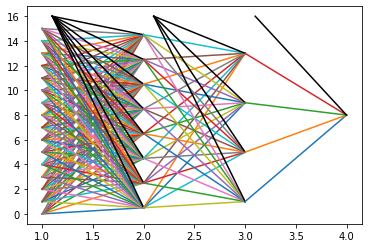

In [0]:

nb_input=16
nb_hidden1=8
nb_hidden2=4
input_points= [(1,i) for i in range(nb_input)]
hidden1_points=[(2,2*i+0.5) for i in range(nb_hidden1)]
hidden2_points=[(3,4*i+1) for i in range(nb_hidden2)]


for x,y in input_points:
  for a,b in hidden1_points:
    plt.plot([x,a],[y,b])
    

for a,b in hidden1_points:
  plt.plot([1.1,a],[16,b],"k")
  for x,y in hidden2_points:
    plt.plot([x,a],[y,b])
      
    
for x,y in hidden2_points:
  plt.plot([2.1,x],[16,y],"k")
  plt.plot([x,4],[y,8])  
    

plt.plot([3.1,4],[16,8],"k");    

## Train, validation, test

### Validons notre approche


* Pour chaque époque: on passe l'intégralité des données `train` par paquet (=batch) de 512. 

* Pour chaque paquet: on fait marcher l'optimizer. 

* A la fin de chaque epoch, on evalue le modèle sur les 10 000 données de validation, sans faire fonctionner l'optimizer (cela provoque une petite pause).

In [0]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))



Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.5902 - binary_accuracy: 0.7603 - val_loss: 0.4490 - val_binary_accuracy: 0.8575
Epoch 2/20
15000/15000 [==============================] - 1s 60us/step - loss: 0.3416 - binary_accuracy: 0.8940 - val_loss: 0.3145 - val_binary_accuracy: 0.8835
Epoch 3/20
15000/15000 [==============================] - 1s 60us/step - loss: 0.2233 - binary_accuracy: 0.9270 - val_loss: 0.2817 - val_binary_accuracy: 0.8877
Epoch 4/20
15000/15000 [==============================] - 1s 59us/step - loss: 0.1640 - binary_accuracy: 0.9474 - val_loss: 0.2798 - val_binary_accuracy: 0.8881
Epoch 5/20
15000/15000 [==============================] - 1s 59us/step - loss: 0.1261 - binary_accuracy: 0.9620 - val_loss: 0.2947 - val_binary_accuracy: 0.8844
Epoch 6/20
15000/15000 [==============================] - 1s 60us/step - loss: 0.1005 - binary_accuracy: 0.9726 - val_loss: 0.3095 - val_binar

Ma méthode `model.fit()` retourne un objet `History` qui a un attribut `history` qui est un dico contenant les valeurs numériques du monitoring. Traçons-les.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

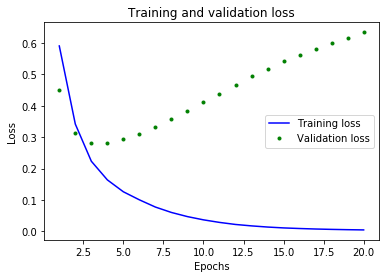

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'g.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

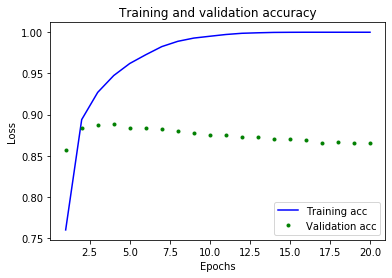

In [0]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();


* la loss décroit sans arrêt: notre optimizer fonctionne. 
* Mais la val_loss remonte après 3 epochs

C'est typique du sur-apprentissage (over-fitting): L'optimizer apprend des motifs spécifique au donnée train et donc qui ne se généralise pas au données `val`, `test` et au futur données entrantes. 


La technique la plus simple pour éviter cela est l'early-stopping: on arrête l'apprentissage quand la val_loss remonte. Deux façon de procéder:

* On enregistre les paramètres (w,b) du modèle à chaque nouveau minimum de la val_loss. A la fin de l'entrainement, on revient au meilleur modèle. 
* On relance entièrement l'entrainement. Puisqu'ici l'entrainement est très rapide, c'est ce que nous faisons:


In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, batch_size=512);


Epoch 1/3
15000/15000 [==============================] - 1s 52us/step - loss: 0.5075 - acc: 0.7840
Epoch 2/3
15000/15000 [==============================] - 1s 39us/step - loss: 0.3071 - acc: 0.9019
Epoch 3/3
15000/15000 [==============================] - 1s 39us/step - loss: 0.2242 - acc: 0.9264


***Attention:*** Contrairement à `sklearn`, l'appelle de la fonction `fit` ne réinitialise pas les paramètres du modèle. Même ma méthode `compile` ne réinitialise pas. Il faut ré-écrire le modèle du début. 

### Evaluons le modèle sur les données tests

In [0]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 2s 76us/step


[0.2971422880554199, 0.88172]

88% de précision: pas mal. Mais les approches de l'"état de l'art" (state-of-the-art) font du 95%.

***A vous:*** $(2\heartsuit)$  Pour le protocole que l'on a utilisé:  était-il vraiment nécessaire d'avoir des données `validation` et `test` distinctes?

### Predictions


In [0]:
hat_y_test_proba=model.predict(x_test)
hat_y_test=(hat_y_test_proba>0.5).astype(int).flatten()

print(hat_y_test[:10])
print(y_test[:10])

[0 1 1 1 1 1 1 0 1 1]
[0 1 1 0 1 1 1 0 0 1]


***A vous:*** Retrouver le chiffre de 88% d'accuracy à partir des 2 vecteurs précédents. 

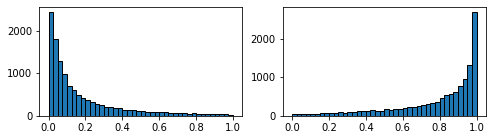

In [0]:
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(8,2))
ax0.hist(hat_y_test_proba[y_test==0],bins=40,edgecolor="k")
ax1.hist(hat_y_test_proba[y_test==1],bins=40,edgecolor="k");

On peut voir que le réseau est assez confiant en ses prédictions: la majorité des probas est proche de 0 ou de 1.


##### Exo: Faites vos propres expérimentation

* $(3\heartsuit)$ essayez en vectorisant les séquences avec `vectorize_sequences_with_count`
* $(3\heartsuit)$ on a essayé 2 couches cachées. Testez avec 1 ou 3. 
* $(3\heartsuit)$ Changez le nombre de neurone par couches (number of units) 
* $(3\heartsuit)$ Essayez la loss `mse`. 
* $(3\heartsuit)$ Essayez des fonctions d'activation `tanh` dans les couches intermédiaires. 

## Lutter contre le sur-apprentissage

Je laisse le texte original de François Cholet, lisez le tranquilement à la maison. 


 Overfitting happens in every single machine learning 
problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. 

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on 
test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet 
modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops 
improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns 
that are specific to the training data but that are misleading or irrelevant when it comes to new data.


To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get 
more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization 
techniques.




### Augmenter la taille des données

C'est le meilleur moyen pour lutter contre le sur-apprentissage. On vera qu'avec des images comme donnée, on peut toujours le faire en introduisant des translation, rotation, chantement de couleur etc... 

Avec nos review, ce n'est pas possible. Passons à d'autre technique. 



### Réduire la taille du réseau

Avec moins de paramètre, le modèle peut apprendre moins de choses par coeur. Lisez le détail à la maison. 



The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is 
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily. There is a compromise to be 
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss.

Let's try this on our movie review classification network.

In [0]:
original_hist=history

In [0]:
smaller_model = keras.models.Sequential()
smaller_model.add(keras.layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(keras.layers.Dense(4, activation='relu'))
smaller_model.add(keras.layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

Comparison:

In [0]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 15000 samples, validate on 25000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.6473 - acc: 0.7500 - val_loss: 0.6081 - val_acc: 0.7848
Epoch 2/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.5551 - acc: 0.8632 - val_loss: 0.5325 - val_acc: 0.8554
Epoch 3/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.4742 - acc: 0.8861 - val_loss: 0.4689 - val_acc: 0.8661
Epoch 4/20
15000/15000 [==============================] - 2s 109us/step - loss: 0.4036 - acc: 0.8998 - val_loss: 0.4153 - val_acc: 0.8721
Epoch 5/20
15000/15000 [==============================] - 2s 111us/step - loss: 0.3440 - acc: 0.9103 - val_loss: 0.3724 - val_acc: 0.8764
Epoch 6/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.2960 - acc: 0.9179 - val_loss: 0.3414 - val_acc: 0.8798
Epoch 7/20
15000/15000 [==============================] - 2s 109us/step - loss: 0.2577 - acc: 0.9266 - val_loss: 0.3207 - 

In [0]:
original_val_loss = original_hist.history['val_loss']


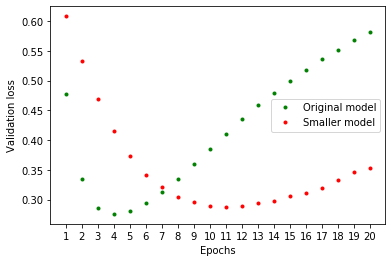

In [0]:
smaller_model_val_loss = smaller_model_hist.history['val_loss']

epochs=np.arange(1,21,1)
plt.plot(epochs, original_val_loss, 'g.', label='Original model')
plt.plot(epochs, smaller_model_val_loss, 'r.', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.xticks(epochs)
plt.legend();

Le petit modèle comment à sur-ajuster plus tard que le gros. Et ses performance se dégradent plus lentement. Par contre, il descend moins bas: le modèle original est donc mieux.  

Essayons maintenant avec un modèle de plus grosse capacité. 

In [0]:
bigger_model = keras.models.Sequential()
bigger_model.add(keras.layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(keras.layers.Dense(512, activation='relu'))
bigger_model.add(keras.layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [0]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 15000 samples, validate on 25000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 188us/step - loss: 0.5322 - acc: 0.7707 - val_loss: 0.5976 - val_acc: 0.7568
Epoch 2/20
15000/15000 [==============================] - 2s 149us/step - loss: 0.2612 - acc: 0.8979 - val_loss: 0.2830 - val_acc: 0.8841
Epoch 3/20
15000/15000 [==============================] - 2s 149us/step - loss: 0.1520 - acc: 0.9409 - val_loss: 0.3184 - val_acc: 0.8732
Epoch 4/20
15000/15000 [==============================] - 2s 148us/step - loss: 0.0732 - acc: 0.9751 - val_loss: 0.5641 - val_acc: 0.7989
Epoch 5/20
15000/15000 [==============================] - 2s 149us/step - loss: 0.0415 - acc: 0.9888 - val_loss: 0.5094 - val_acc: 0.8341
Epoch 6/20
15000/15000 [==============================] - 2s 150us/step - loss: 0.0064 - acc: 0.9995 - val_loss: 0.5668 - val_acc: 0.8760
Epoch 7/20
15000/15000 [==============================] - 2s 149us/step - loss: 5.2377e-04 - acc: 1.0000 - val_loss: 0.674

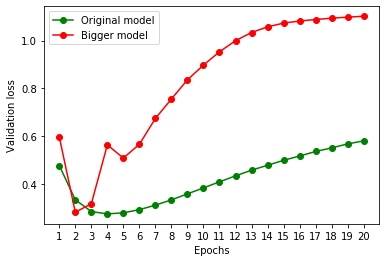

In [0]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'go-', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'ro-', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.xticks(epochs)
plt.legend();


Le gros modèle sur-ajuste plus sévèrement. Sa loss de validation est plus bruités. 

Quand à sa loss de train: 

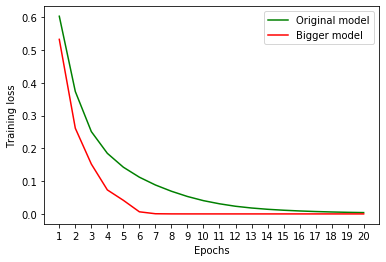

In [0]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'g', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'r', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.xticks(epochs)
plt.legend();

### L2 weight regularization (=ridge=weight decay)


  _Occam's Razor_ principle: étant donnée 2 explications valable, celle qui est la meilleur est la plus simple. 
   

![toot](https://drive.google.com/uc?export=view&id=19UwF49NvDNwl7NlyTkn_5WZl1bF9AL5P)


Cela s'applique aussi au modèles de machine learning: Un modèle simple dans ce contexte, est celui dont la distribution des paramètre la moins d'entropy. Pour  régulariser on peut forcer les poids de prendre des petites valeurs, ce qui rend la distribution des poids plus régulière. C'est la   "weight regularization" ou "pénalisation des poids". 

Pour ce faire on ajouter un terme à la loss, qui est grand quand les poids sont grands en valeur absolue. 
Les deux techniques principales sont: 

* Régularisation L1 ou lasso:
$$
loss_\alpha= loss + \alpha \sum_i \|w_i\|
$$
* Régularisation L2 ou ridgde:
$$
loss_\alpha= loss +\alpha \sum_i (w_i)^2
$$


In [0]:
l2_model = keras.models.Sequential()
l2_model.add(keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

***Attention:*** En keras, le terme de pénalisation sur la loss n'est ajouté que pour le traning et la validation. Pas lors du test (=appelle de la fonction `model.evaluate`). 


In [0]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Train on 15000 samples, validate on 25000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 109us/step - loss: 0.6193 - acc: 0.7256 - val_loss: 0.5264 - val_acc: 0.8353
Epoch 2/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.4467 - acc: 0.8820 - val_loss: 0.4321 - val_acc: 0.8756
Epoch 3/20
15000/15000 [==============================] - 1s 90us/step - loss: 0.3507 - acc: 0.9124 - val_loss: 0.4116 - val_acc: 0.8636
Epoch 4/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.2941 - acc: 0.9279 - val_loss: 0.3600 - val_acc: 0.8821
Epoch 5/20
15000/15000 [==============================] - 1s 90us/step - loss: 0.2659 - acc: 0.9354 - val_loss: 0.3618 - val_acc: 0.8769
Epoch 6/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.2389 - acc: 0.9460 - val_loss: 0.3594 - val_acc: 0.8768
Epoch 7/20
15000/15000 [==============================] - 1s 88us/step - loss: 0.2228 - acc: 0.9489 - val_loss: 0.3558 - val_ac

***A vous:*** Considérons la fonction loss non-régularisée $loss(w)$. La descente de gradient (toute simple) correspond à changer les paramètres selon la règle suivante: 
$$
w_i \leftarrow w_i - \ell \, \frac{\partial loss}{\partial w_i}
$$
où $\ell$ est le learning rate.  Considérons la loss régularisée: $ loss(w) + \alpha \sum_i w_i^2$. Comment $(1\heartsuit)$ s'écrit la descente de gradient maintenant ? Cela justifie le fait que le coefficient $\alpha$, dans le cadre ridge, soit parfois appelé `loss_decay`.






***Remarques:*** on doit bien ajuster $\alpha$:

* $\alpha$ trop petit la pénalisation est inefficace, $\alpha$ trop grand le modèle n'apprend plus rien (tous les poids vont vers 0). 
 
*  Typiquement, $\alpha$ peut-être choisi par cross validation, en essayant par exemple $ 0.1,0.01,0.001,0.0001)$ en observant les courbes loss-val et loss. 


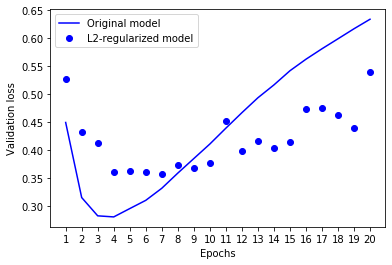

In [0]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.xticks(epochs)
plt.legend();

On voit ci-dessus que le modèle pénalisé est plus résistant à l'over-fitting. 

Observons la distribution des poids:

Text(0.5, 1.0, 'bias')

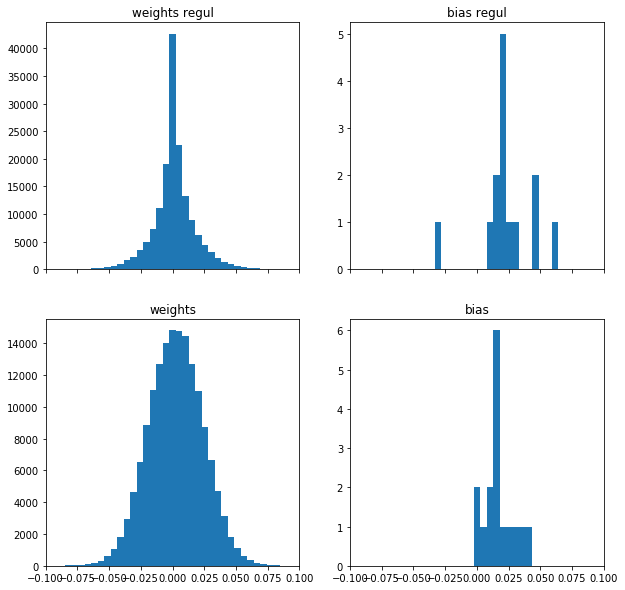

In [0]:
layer_index=0

l2_weights, l2_biases = l2_model.layers[layer_index].get_weights()
original_weights, original_biases = model.layers[layer_index].get_weights()

fig,axs=plt.subplots(2,2,sharex=True,figsize=(10,10))

bins=np.linspace(-0.1,0.1,40)

axs[0,0].hist(l2_weights.reshape(-1),bins=bins)
axs[0,0].set_title("weights regul")
axs[0,0].set_xlim(-0.1,0.1)
axs[0,1].hist(l2_biases.reshape(-1),bins=bins)
axs[0,1].set_title("bias regul")
axs[0,1].set_xlim(-0.1,0.1)

axs[1,0].hist(original_weights.reshape(-1),bins=bins)
axs[1,0].set_title("weights")
axs[1,1].hist(original_biases.reshape(-1),bins=bins);
axs[1,1].set_title("bias")

***Remarque:*** les biais ne sont pas comptabilisé dans la pénalisation: car le role du biais est de recentrer les poids, et il ne faut surtout pas être radin sur le recentrage.

***A vous:*** Pourquoi $(1\heartsuit)$ d'après vous il faut que les poids soient en permanence recentrer autour de zéro? 

***A vous:*** Refaites l'entrainement $(1\heartsuit)$  avec une régularisation l1 (dites lasso). Cette régularisation est connue pour mettre à zéro beaucoup de paramètres. Une bonne illustratino est de superposer les  3 histrogrammes: pénalisation L1, L2 et sans pénalisation $(1\heartsuit)$. 


La régularisation l1 est donc beaucoup utiliser dans un but de sélection de variable. 

On peut mélanger les deux pénalisation, on parle alors "d'elastic-net". En keras:


    # L1 and L2 regularization at the same time
    regularizers.l1_l2(l1=0.001, l2=0.001)



### Le dropout



***Principe:***  A chaque itération de l'apprentissage, on gelle une partie aléatoire des neurones: c.à.d qu'on actualise pas leur poids en fonction des données. A chaque paquet de donnée on retire aléatoirement les neurones gelés. Ainsi, toutes les neurones ne voient pas toutes les données. Cela empêche le réseau dans sa totalité d'apprendre par coeur les données train. 

Le paramètre: "dropout rate" (dr) correspond à la proportion des neurone que l'on gele. 

Lors de la phase de test, on ne gele plus aucun neurone. 




***Réalisation du dropout:*** En fait on ne gèle pas vraiment les poids, mais on multiplie la sortie des layer par des 0 ou 1 aléatoire. Les zéro bloqueront la rétro-propagation du gradient. 

    # At training time:
    layer_output *= np.choice([0,1], [dr,1-dr], size=layer_output.shape)
    
   
    

Mais cela pose un problème: pendant la phase de test, comme on ne multiplie pas par des zéro, la sortie est globalement plus petite. Les fonction d'activation risquent de moins censurer. Du coup pendant le teste on fait un scaling:

    # At testing time: we are scaling *down*:
    layer_output *= (1-dr)

***Réalisation de l'inverse-dropout:*** Mais maintenant, tout le monde (keras) pratique l'inverse drop-out: il s'agit de faire le scaline inverse durant le train, pour faire le moins d'opération possible dans la phase de test (qui est identique à la phase de production). 


    # At training time:
    layer_output *=  1/(1-dr) * np.choice([0,1], [dr,1-dr], size=layer_output.shape)
    
    # At testing time
    layer_output = layer_output



Si vous voulez plus de détail [lisez ceci](http://cs231n.github.io/neural-networks-2/#reg)



***Remarque:*** Une des technique très récente est de laisser actif le dropout pendant la phase de teste: les résultats du modèle deviennent probabiliste: on teste plusieurs fois le modèle sur les même données, ce qui donne une distribution des résutats. Cela permet de quantifier l'incertitude de notre modèle. 
    
    

In [0]:
dpt_model = keras.models.Sequential()
dpt_model.add(keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(keras.layers.Dropout(rate=0.5)) # influence les grandients de la couche précédente
dpt_model.add(keras.layers.Dense(16, activation='relu'))
dpt_model.add(keras.layers.Dropout(rate=0.5)) # influence les grandients de la couche précédente
dpt_model.add(keras.layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [0]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

In [0]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'go-', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'ro-', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.xticks(epochs)
plt.legend();

Pour récapituler, pour combattre l'apprentissage on peut: 

* collecter plus de donnée, ou les enrichir
* réduire la capacité du modèle
* pénaliser les poids
* ajouter du dropout


Des chercheurs ont aussi montré qu'une moindre précision dans les flotants (float32 au lieu de float64), introduisait un flou qui limiter le sur-apprentissage. On va même plus loin en randomisant les paramétres: c'est tout la théorie des réseaux bayesiens. 


## Scores

Résumons: 
* A partir des x_test, notre modèle prédit des proba hat_y_test
* On prend un seuil de 0.5 puis on décide que hat_y_test=(hat_y_test>0.5)
* On va maintenant mesurer de différentes façon l'écart entre  hat_y_test et le vrai y_test


En classification binaire, l'une des deux classes est appelée positive l'autre négative. 

Traditionnellement, la classe positive est celle qui nous intéresse le plus ex: présence d'une maladie. Elle est souvent minoritaire. Ici, on décide que la classe positive c'est la classe 1: celle des critiques positives de film. 



In [0]:
print(hat_y_test_proba)
print(hat_y_test)
print(y_test)

[[0.35864556]
 [0.99926525]
 [0.9783988 ]
 ...
 [0.17882338]
 [0.28468576]
 [0.53104156]]
[0 1 1 ... 0 0 1]
[0 1 1 ... 0 0 0]


###  Matrice de confusion

* les lignes indiques les vrai classes
* les colonnes les prédiction
* ex: l'intersection entre la première ligne et la première colonne indique le nombre de négatif bien classé. 


In [0]:
import sklearn.metrics
C=sklearn.metrics.confusion_matrix(y_test, hat_y_test)
"a dataframe just for presentation"
C_df=pd.DataFrame(data=C,columns=[ r"^-",r"^+"],index=[r"-",r"+"])
C_df

,^-,^+
-,10732,1768
+,1125,11375


### Vrais/Faux positif/Negatif

On donne des noms à chacune des casses de la matrice de confusion: 
$$
\begin{array}{c|cc}
& \hat - & \hat + \\
\hline
- & TN & FP \\
+ & FN &  TP   
\end{array}
$$

In [0]:
TN=C[0,0]
FN=C[1,0]
FP=C[0,1]
TP=C[1,1];

***A vous:*** Faites les calculs demandé ci-dessous sans utiliser l'ordinateur:
* Indiquez  $(1\heartsuit)$  quel serait le résultat de  `confusion_matrix(y_test, y_test)`?  
* Indiquez  $(2\heartsuit)$  quel serait le résultat de  `confusion_matrix(y_test, y_rand)` avec `y_rand` un vecteur aléatoire de 0 et de 1?

### Précision/rappel


$$
\begin{align}
\text{precision} & =\frac{TP}{TP+FP}=  \frac{+\cap \hat +}{\hat +} = \text{accuracy of the positive predictions}\\
\text{recall} & =\frac{TP}{TP+FN} = \frac{+\cap \hat +}{ +} = \text{ratio of positive instances that are correctly detected}
\end{align}
$$

* Précision proche de 1: la plupart des prédictions son bonnes. 
* Rappel proche de 1: on détecte la plupart des positifs

Si notre modèle détecte une maladie, il faut avoir un bon rappel. Surtout si on peut ensuite faire des examen supplémentaire pour éliminer les faux positifs. 


In [0]:
print("precision_score: %.2f"%(TP/(TP+FP)))
print("recall_score: %.2f"%(TP/(TP+FN)))

precision_score: 0.87
recall_score: 0.91


### F1 score 

C'est la moyenne harmonique de la précision et du rappel: 
$$
F_1= \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}
$$
 Le modèle a un bon F1-score quand précision et rappel sont tous les deux grands. 






##  Changeons le seuil

On n'est pas obligé de prendre 0.5 comme seuil. Typiquement, on peut favoriser la classe minoritaire. 

Avant de choisir un seuil, il est intéressant de regarder des courbes qui présente les résultats pour tous les seuils possibles.


Attention, certains modèle (ex: le gradient-stochastique de `sklearn`) ne renvoient pas des probas, mais simplement un score réel ex: entre -7000 et +9000. Mais le principe est le même: plus le score est grand et plus il faut classe la ligne dans les positifs. Ce qui suit reste valide: remplacer simplement l'intervalle [0,1] par l'intervalle [-7000,+9000].  



### Precision/Recall Tradeoff 


(0, 1)

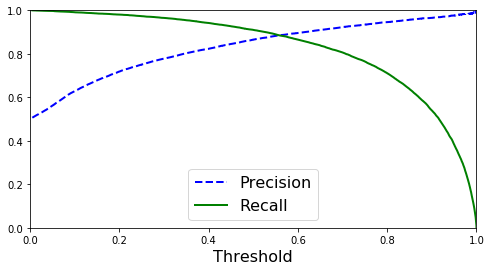

In [0]:
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y_test, hat_y_test_proba)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower center", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])

*   seuil  grand $\Rightarrow$ $\hat +$ petit $\Rightarrow$ grande précision et petit rappel.
*  Cas extrème:  Seuil $=1$  $\Rightarrow$ $\hat + = \emptyset$  $\Rightarrow$
$$
\begin{align}
\text{precision} & =  \frac{+\cap \hat +}{\hat +} = \frac 0 0 =  1 \\
\text{rappel}    & =  \frac{+\cap \hat +}{+}  = 0
\end{align}
$$


* Retenez: avec un grand seuil, on est très exigent pour classer les données +, donc je ne classe que des vrais +, donc grande précision.  




*   seuil  petit $\Rightarrow$ $\hat +$ grand $\Rightarrow$ petite précision et grand rappel.
*   Cas extrème:  Seuil=0 $\Rightarrow$ $\hat + = all$  $\Rightarrow$
$$
\begin{align}
\text{precision} & = \frac{+\cap \hat +}{+} =  \frac{+}{all} = (\text{ ici } \frac 1 2 )  \\
\text{rappel}    & =  \frac{+\cap \hat +}{+}  =\frac{+}{+} =  1
\end{align}
$$
* retenez: avec un petit seuil,  on classe plein de donnée +, on ne va pas en rater beaucoup: grand rappel. 







Vous pouvez choisir votre seuil en fonction de cette courbe, ou de la suivante:

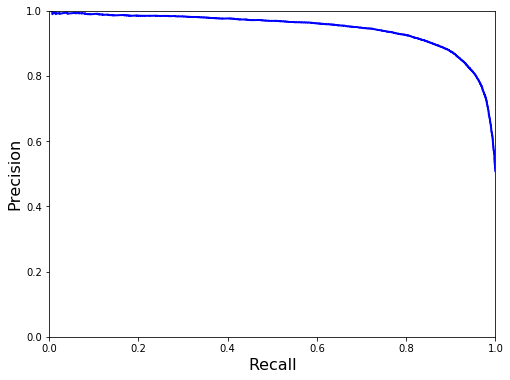

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

Sur cette courbe, je choisirais le seuil qui correspond à un recall de 0.8: juste avant sa chutte. 

### La courbe ROC

ROC signifie receiver operating characteristic (ROC). C'est une coubr très utilisée pour observer l'effet du seuillage:


* TPR = recall = ratio of positive instances that are correctly classified=
$$
\frac{+\cap \hat +}{ +}
$$
*  FPR =  ratio of negative instances that are incorrectly classified as positive =
$$
\frac{-\cap \hat +}{ - }
$$

 

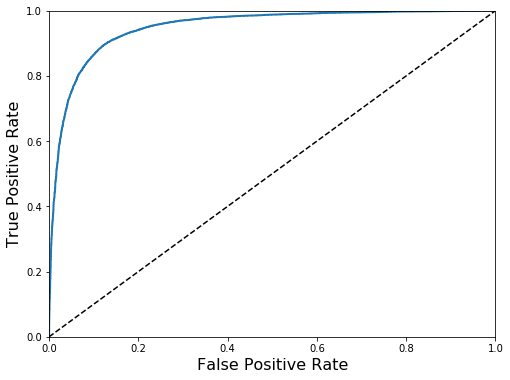

In [0]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, hat_y_test_proba)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)


Le score AUC (area under the curve) c'est l'aire sous la courbe ROC. Au mieux elle vaut 1. Au pire 0.5. 


In [0]:
sklearn.metrics.roc_auc_score(y_test, hat_y_test_proba)

0.9492224736

###  courbe ROC à la main  $\flat$

Pour le plaisir, programmons notre propre courbe ROC.

In [0]:
def TPR_FPR(threshold: float, y: np.ndarray, scores: np.ndarray):
  
    """ 
    Cette fonction renvoie:
        * le taux de vrais positifs : fractions des positifs qui sont classés positifs
        * le taux de faux  positifs : fractions des négatifs qui sont classés positifs.
    """
   
   
    """ on classe positifs (=en 1) les individus dont la proba estimée d'être 1 est > threshold   """
    y_hat = (scores >= threshold).astype(np.int)

    """Calculons les indexes des positifs et des négatifs. """
    index_P = (y == 1)
    index_N = (y == 0)
    
    
    TPR = np.sum(y_hat[index_P] == 1) / np.sum(index_P)
    FPR = np.sum(y_hat[index_N] == 1) / np.sum(index_N)

    return TPR, FPR

Effectuons un programme test. On se donne deux classes: la classe 0=negatif, et 1=positif. On suppose que l'on a des probabilité et des classes comme ceci:

In [0]:
a=[
    [0.49,0.51],
    [0.3,0.7],
    [0.1,0.9],
    [0.6,0.4],
    [0.55,0.45],
    [0.2,0.8]
]
probas=np.array(a)
print("probas:\n",probas)
true_cl=np.array([1,1,1,0,1,0])
print("true_cl:\n",true_cl)

probas:
 [[0.49 0.51]
 [0.3  0.7 ]
 [0.1  0.9 ]
 [0.6  0.4 ]
 [0.55 0.45]
 [0.2  0.8 ]]
true_cl:
 [1 1 1 0 1 0]


Avec un seuil  `threshold=0.5` on trouve:

In [0]:
estimated_cl=(probas>0.5).astype(np.int)[:,1]
print("estimated_cl:\n",estimated_cl)

estimated_cl:
 [1 1 1 0 0 1]


Ainsi à l'oeil on voit que

*  TPR = 3/4
*  FPR = 1/2

In [0]:
TPR_FPR(threshold=0.5, y=true_cl, scores=probas[:,1])

(0.75, 0.5)

***A vous:*** Blindez la fonction `TPR_FPR`: 

* $(2\heartsuit)$ Il y a un problème mathématique si on rentre `y=np.zeros(6)`. 
* $(2\heartsuit)$ Il y a un problème  si l'utilisateur (quel couillon!) rentre `y=[1,1,1,0,1,0]` au lieu de  `y=np.array([1,1,1,0,1,0])` (le `==` ne fonctionne pas pareil sur les listes et sur les tenseur numpy). 

Remarque: l'instruction de typage  dans l'argument de la fonction `y: np.ndarray` fournis uniquement un warning si l'utilisateur a une IDE qui vérifie le typage. Ce n'est pas le cas pour l'instant sur les notebook. 

[1.0, 0.99952, 0.99896, 0.99816, 0.9976, 0.99728, 0.99552, 0.99464, 0.99376, 0.99272, 0.99088, 0.99016, 0.9892, 0.988, 0.98704, 0.98544, 0.98496, 0.98376, 0.98256, 0.98136, 0.98032, 0.97896, 0.97752, 0.97624, 0.97448, 0.97288, 0.97096, 0.96992, 0.96824, 0.96632, 0.9648, 0.9628, 0.96096, 0.95864, 0.9564, 0.95392, 0.95152, 0.94896, 0.94568, 0.94328, 0.94088, 0.93728, 0.93432, 0.93192, 0.92872, 0.92536, 0.92216, 0.91816, 0.91424, 0.912, 0.908, 0.90472, 0.90104, 0.8968, 0.89216, 0.88624, 0.88248, 0.87824, 0.87256, 0.8676, 0.86248, 0.8572, 0.8516, 0.84616, 0.84104, 0.83448, 0.8272, 0.82048, 0.81512, 0.8088, 0.80024, 0.79208, 0.78296, 0.7752, 0.76712, 0.7564, 0.74704, 0.73552, 0.72552, 0.71392, 0.70048, 0.68576, 0.67112, 0.65704, 0.64072, 0.62272, 0.60552, 0.5856, 0.56624, 0.54176, 0.51824, 0.49072, 0.4588, 0.42256, 0.3848, 0.34168, 0.29352, 0.22848, 0.14336, 8e-05]


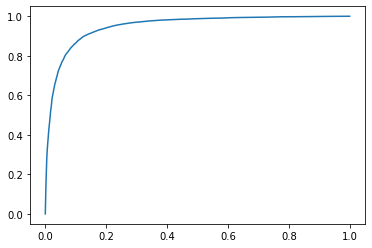

In [0]:
thresholds=np.linspace(np.min(hat_y_test_proba),np.max(hat_y_test_proba),100)
a=[]
b=[]
for th in thresholds:
    fpr1, tpr1 =TPR_FPR(th,y_test, hat_y_test_proba)
    a.append(fpr1)
    b.append(tpr1)
print(a)

plt.plot(b,a);

### Comparons avec les forêts aléatoires

On detaillera dans un prochain TP comment marche les forêts aléatoires. 

Attention, les arbres aléatoires ne renvoie pas une proba: le `RandomForestClassifier` de `sklearn` n'a pas de méthode `predict_proba`. 



Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. Due to the way it works, the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the  given class (e.g., 70% chance that the image represents a 5).

In [0]:
import sklearn.ensemble
forest_clf = sklearn.ensemble.RandomForestClassifier(random_state=42)
forest_clf.fit(x_train,y_train)
hat_y_test_proba_forest=forest_clf.predict_proba(x_test)

print(hat_y_test_proba_forest[:10,:])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.7 0.3]
 [0.5 0.5]
 [0.3 0.7]
 [0.4 0.6]
 [0.5 0.5]
 [0.3 0.7]
 [0.4 0.6]
 [0.6 0.4]
 [0.4 0.6]
 [0.4 0.6]]


But to plot a ROC curve, you need one scores, not two probabilities. A simple solution is to use the positive class’s probability as the score: 

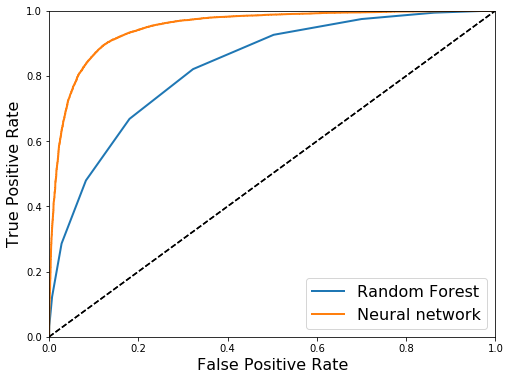

In [0]:
y_scores_forest = hat_y_test_proba_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = sklearn.metrics.roc_curve(y_test,hat_y_test_proba_forest[:,1])
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr, tpr, "Neural network")

plt.legend(loc="lower right", fontsize=16);

La forêt aléatoire esst moins bien. Mais c'ets normal, car on n'a pas du tout réglé les hyper-paramètres. 